C:\Users\USER\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
📰 본문 분석: 100%|██████████| 14214/14214 [01:18<00:00, 181.95it/s]



 침수면적 vs 기사 언급량
Spearman 상관계수: 0.364, p-value: 0.1819

 침수는 많은데 보도가 적은 시도 TOP 5:
     시도명  언급횟수          침수면적      침수대비기사비율
14   강원도     9  5.614059e+07  1.603118e-07
13   제주도    84  4.930215e+07  1.703780e-06
6   경상남도  7355  3.220965e+09  2.283477e-06
9   전라남도  6609  8.782575e+08  7.525128e-06
12  전라북도  1650  6.548091e+07  2.519818e-05

 침수에 비해 보도가 많은 시도 TOP 5:
      시도명   언급횟수          침수면적  침수대비기사비율
10  인천광역시   1985  1.392355e+05  0.014256
0   서울특별시  11309  5.593913e+06  0.002022
7   대전광역시   1651  4.173725e+06  0.000396
4   부산광역시   9219  6.136868e+07  0.000150
8    충청남도   2258  2.398596e+07  0.000094

 전체 정렬된 도별 데이터:
      시도명   언급횟수          침수면적      침수대비기사비율
0   인천광역시   1985  1.392355e+05  1.425642e-02
1   서울특별시  11309  5.593913e+06  2.021662e-03
2   대전광역시   1651  4.173725e+06  3.955699e-04
3   부산광역시   9219  6.136868e+07  1.502232e-04
4    충청남도   2258  2.398596e+07  9.413840e-05
5   울산광역시   2638  4.721854e+07  5.586789e-05
6    경상북도   7626  1.543771e+08  4.939852e-05
7   광주광역시  

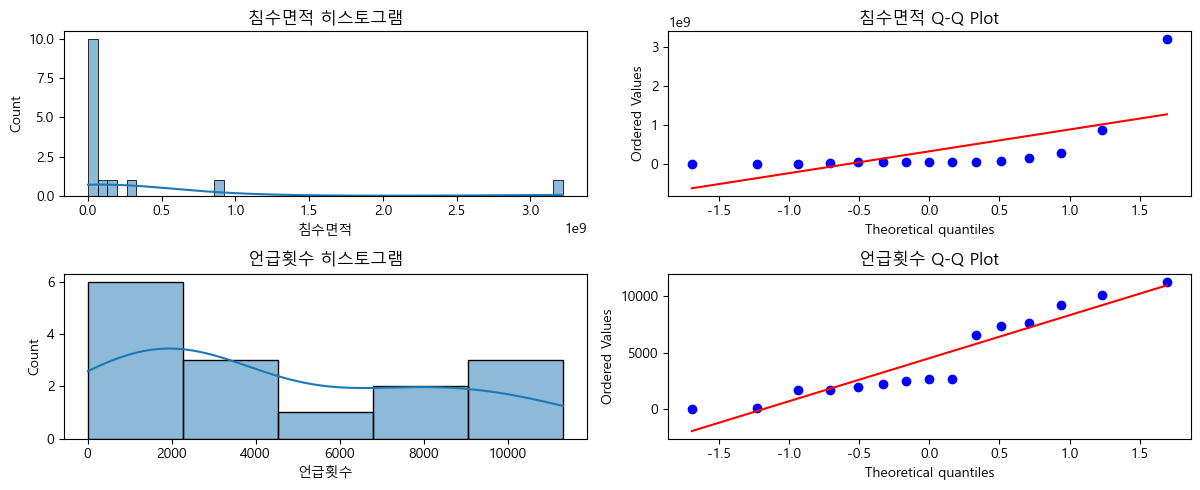

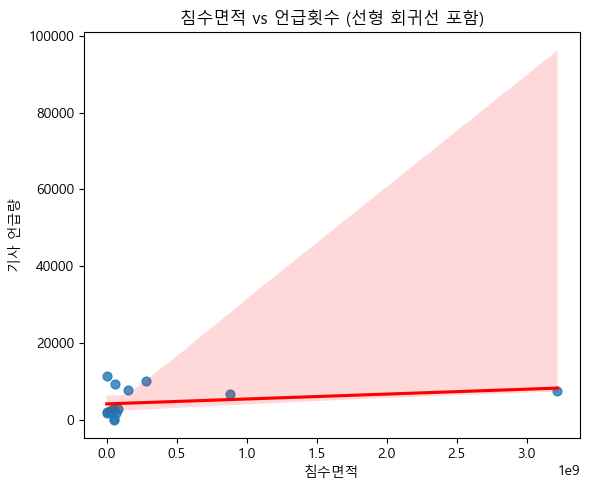

In [1]:
# -*- coding: utf-8 -*-
"""
시도별 뉴스 언급량 vs 침수면적 스크립트 (침수면적 기준 분석)
"""

import re
from pathlib import Path
from collections import defaultdict
import pandas as pd
from tqdm import tqdm
from scipy.stats import spearmanr
from dataclasses import dataclass

# --------------------------------------------------
# 0. 경로 설정
# --------------------------------------------------
ROOT = Path.cwd() 
NEWS_FILE   = ROOT / "NewsResult_20110101-20221231.xlsx"
ADMIN_FILE  = ROOT / "국토교통부_전국 법정동_20250415.csv"
SUBWAY_FILE = ROOT / "전국_지하철역_시도.csv"
FLOOD_FILE  = ROOT / "시도별_침수면적_통합_2011_2022.csv"
OUT_FILE    = ROOT / "sido_mention_vs_area.csv"
PUMP_DF     = ROOT / "전국배수펌프장표준데이터.csv"

# --------------------------------------------------
# 1. 시도 표준화
# --------------------------------------------------
SIDO_CANON = {
    '서울특별시':  ['서울특별시', '서울'],
    '부산광역시':  ['부산광역시', '부산'],
    '대구광역시':  ['대구광역시', '대구'],
    '인천광역시':  ['인천광역시', '인천'],
    '광주광역시':  ['광주광역시', '광주'],
    '대전광역시':  ['대전광역시', '대전'],
    '울산광역시':  ['울산광역시', '울산'],
    '세종특별자치시': ['세종특별자치시', '세종'],
    '경기도':      ['경기도', '경기'],
    '강원특별자치도': ['강원특별자치도', '강원'],
    '충청북도':    ['충청북도', '충북'],
    '충청남도':    ['충청남도', '충남'],
    '전라북도':    ['전라북도', '전북'],
    '전라남도':    ['전라남도', '전남'],
    '경상북도':    ['경상북도', '경북'],
    '경상남도':    ['경상남도', '경남'],
    '제주특별자치도': ['제주특별자치도', '제주'],
}

# --------------------------------------------------
# 클래스 정의
# --------------------------------------------------

class PathConfig:
    def get_paths(self):
        return {
            "NEWS_FILE": NEWS_FILE,
            "ADMIN_FILE": ADMIN_FILE,
            "SUBWAY_FILE": SUBWAY_FILE,
            "FLOOD_FILE": FLOOD_FILE,
            "OUT_FILE": OUT_FILE,
            "PUMP_DF": PUMP_DF
        }

class NewsLoader:
    def load(self, news_file: Path) -> pd.DataFrame:
        news = pd.read_excel(news_file)
        return news

class AdminIndexer:
    HANGUL_RE = re.compile(r'^[\uac00-\ud7a3]+$')

    def __init__(self):
        self.token2sidos = defaultdict(set)

    def _add(self, tok, sido, *, allow_short=False):
        if not tok or len(tok) < 2 or not self.HANGUL_RE.fullmatch(tok): 
            return
        self.token2sidos[tok.strip()].add(sido)

    def add_with_variants(self, raw, sido):
        if not isinstance(raw, str): 
            return
        raw = raw.strip()
        if not raw:
            return

        self._add(raw, sido)
        trimmed = re.sub(r'(구|군|시|읍|면|동|리|역)$', '', raw)
        if len(trimmed) >= 3:
            self._add(trimmed, sido)
        if not raw.endswith('역'):
            self._add(f"{raw}역", sido)

    def build(self, admin_file: Path) -> "AdminIndexer":
        admin = pd.read_csv(admin_file, encoding='utf-8').fillna("")
        for _, row in admin.iterrows():
            sido = str(row['시도명']).strip()
            for col in ('시군구명', '읍면동명', '리명'):
                self.add_with_variants(row[col], sido)
        return self

class SubwayIndexer:
    def __init__(self, token2sidos: defaultdict):
        self.token2sidos = token2sidos

    def add_with_variants(self, raw, sido):
        if not isinstance(raw, str): 
            return
        raw = raw.strip()
        if not raw:
            return
       
        HANGUL_RE = re.compile(r'^[\uac00-\ud7a3]+$')
        def _add(tok, sido):
            if not tok or len(tok) < 2 or not HANGUL_RE.fullmatch(tok): 
                return
            self.token2sidos[tok.strip()].add(sido)

        _add(raw, sido)
        trimmed = re.sub(r'(구|군|시|읍|면|동|리|역)$', '', raw)
        if len(trimmed) >= 3:
            _add(trimmed, sido)
        if not raw.endswith('역'):
            _add(f"{raw}역", sido)

    def build(self, subway_file: Path) -> "SubwayIndexer":
        sub = pd.read_csv(subway_file, encoding='utf-8').fillna("")
        for _, row in sub.iterrows():
            self.add_with_variants(row['역사명'], str(row['SIDO_NM']).strip())
        return self

@dataclass
class TokenIndex:
    clean_token2sido: dict
    token_patterns: list

class TokenIndexer:
    def __init__(self, token2sidos: defaultdict):
        self.token2sidos = token2sidos

    def finalize(self) -> TokenIndex:
        clean_token2sido = {tok: list(sidos)[0] 
                            for tok, sidos in self.token2sidos.items() 
                            if len(sidos) == 1}
        token_patterns = [(tok, re.compile(fr'{re.escape(tok)}')) 
                          for tok in sorted(clean_token2sido, key=len, reverse=True)]
        return TokenIndex(clean_token2sido=clean_token2sido, token_patterns=token_patterns)

    def count_mentions(self, news_df: pd.DataFrame, body_col: str, token_index: TokenIndex) -> pd.DataFrame:
        sido_counts = defaultdict(int)
        for text in tqdm(news_df[body_col].fillna(""), desc="📰 본문 분석"):
            if not isinstance(text, str): 
                continue
            for tok, pat in token_index.token_patterns:
                hits = len(pat.findall(text))
                if hits:
                    sido = token_index.clean_token2sido[tok]
                    sido_counts[sido] += hits

        mention_df = pd.Series(sido_counts, name='언급횟수').reset_index()
        mention_df.columns = ['시도명', '언급횟수']
        return mention_df

class FloodLoader:
    def load_and_aggregate(self, flood_file: Path) -> pd.DataFrame:
        flood_df = pd.read_csv(flood_file, encoding='utf-8').fillna("")
        flood_df = flood_df.rename(columns={
            'SIDO_NAME': '시도명',
            '침수흔적_건수': '침수흔적수',
            '침수면적_합계': '침수면적'
        })
        if '시도명' not in flood_df.columns:
            flood_df['시도명'] = flood_df['시군구명'].str.extract(r'^([^\s]+)')

        flood_sido_df = (
            flood_df.groupby('시도명')['침수면적']
            .sum().reset_index()
        )
        flood_sido_df = flood_sido_df[flood_sido_df['침수면적'] > 0]
        return flood_sido_df

class Merger:
    def merge_and_make_metrics(self, mention_df: pd.DataFrame, flood_sido_df: pd.DataFrame) -> pd.DataFrame:
        merged = pd.merge(mention_df, flood_sido_df, on='시도명', how='inner')
        merged['침수대비기사비율'] = merged['언급횟수'] / merged['침수면적']
        return merged

class Analyzer:
    def spearman(self, merged: pd.DataFrame):
        corr, pval = spearmanr(merged['침수면적'], merged['언급횟수'])
        return corr, pval

class Reporter:
    def __init__(self, out_file: Path):
        self.out_file = out_file

    def print_rankings(self, merged: pd.DataFrame):
        print("\n 침수면적 vs 기사 언급량")
        corr, pval = spearmanr(merged['침수면적'], merged['언급횟수'])
        print(f"Spearman 상관계수: {corr:.3f}, p-value: {pval:.4f}")

        print("\n 침수는 많은데 보도가 적은 시도 TOP 5:")
        print(merged.sort_values('침수대비기사비율').head(5)[['시도명', '언급횟수', '침수면적', '침수대비기사비율']])

        print("\n 침수에 비해 보도가 많은 시도 TOP 5:")
        print(merged.sort_values('침수대비기사비율', ascending=False).head(5)[['시도명', '언급횟수', '침수면적', '침수대비기사비율']])

        print("\n 전체 정렬된 도별 데이터:")
        print(merged.sort_values('침수대비기사비율', ascending=False).reset_index(drop=True)[['시도명', '언급횟수', '침수면적', '침수대비기사비율']])

        # 침수면적/보도량 순위 (원본 출력 유지)
        print("\n 전체 침수면적 순위:")
        print(merged.sort_values('침수면적', ascending=False)[['시도명', '침수면적']].reset_index(drop=True))

        print("\n 전체 보도량 순위:")
        print(merged.sort_values('언급횟수', ascending=False)[['시도명', '언급횟수']].reset_index(drop=True))

    def save_csv(self, merged: pd.DataFrame):
        merged.to_csv(self.out_file, index=False, encoding='utf-8-sig')
        print(f"\n 결과 저장 완료 → {self.out_file}")

class PumpAnalyzer:
    def compute(self, merged: pd.DataFrame, pump_df_path: Path) -> pd.DataFrame:
        pump_df = pd.read_csv(pump_df_path, encoding='cp949')
        pump_count = pump_df['시도명'].value_counts().reset_index()
        pump_count.columns = ['시도명', '배수펌프장수']

        merged_pump = pd.merge(merged, pump_count, on='시도명', how='left')
        merged_pump['배수펌프장수'] = merged_pump['배수펌프장수'].fillna(0)
        merged_pump['침수면적대비펌프장수'] = merged_pump['배수펌프장수'] / merged_pump['침수면적']
        merged_pump['침수면적대비기사비율'] = merged_pump['언급횟수'] / merged_pump['침수면적']

        corr_pump_ratio, pval_pump_ratio = spearmanr(
            merged_pump['침수면적대비펌프장수'],
            merged_pump['침수면적대비기사비율']
        )

        print(f"\n 침수면적 대비 배수펌프장 수 vs 침수면적 대비 기사 비율")
        print(f"Spearman 상관계수: {corr_pump_ratio:.3f}, p-value: {pval_pump_ratio:.4f}")

        return merged_pump

# --------------------------------------------------
# 파이프라인 조립
# --------------------------------------------------

class FloodNewsPipeline:
    def __init__(self):
        self.path_config = PathConfig()
        self.news_loader = NewsLoader()
        self.admin_indexer = AdminIndexer()
        self.token_indexer = None 
        self.flood_loader = FloodLoader()
        self.merger = Merger()
        self.analyzer = Analyzer()
        self.reporter = None 
        self.pump_analyzer = PumpAnalyzer()

        # 산출물
        self.mention_df = None
        self.flood_sido_df = None
        self.merged = None
        self.merged_pump = None

    def run(self):
        paths = self.path_config.get_paths()
        self.reporter = Reporter(paths["OUT_FILE"])

        # 1) 뉴스 로드
        news = self.news_loader.load(paths["NEWS_FILE"])
        body_col = '위치' if '위치' in news.columns else news.columns[0]

        # 2) 토큰 사전 구축
        admin_idx = self.admin_indexer.build(paths["ADMIN_FILE"])
        subway_idx = SubwayIndexer(admin_idx.token2sidos).build(paths["SUBWAY_FILE"])

        # 시도 canonical 추가
        for canon, aliases in SIDO_CANON.items():
            for a in aliases:
                admin_idx._add(a, canon, allow_short=True)

        # 토큰 인덱스 finalize
        self.token_indexer = TokenIndexer(admin_idx.token2sidos)
        token_index = self.token_indexer.finalize()

        # 3) 뉴스 본문 토큰 매칭 → 시도별 언급량 산출
        self.mention_df = self.token_indexer.count_mentions(news, body_col, token_index)

        # 4) 침수면적 시도 합계
        self.flood_sido_df = self.flood_loader.load_and_aggregate(paths["FLOOD_FILE"])

        # 5) 병합 및 지표
        self.merged = self.merger.merge_and_make_metrics(self.mention_df, self.flood_sido_df)

        # 6) 상관 + 출력 + 저장
        corr, pval = self.analyzer.spearman(self.merged)
        self.reporter.print_rankings(self.merged)
        self.reporter.save_csv(self.merged)

        # 7) 펌프장 분석
        self.merged_pump = self.pump_analyzer.compute(self.merged, paths["PUMP_DF"])

        # 리턴
        return {
            "mention_df": self.mention_df,
            "flood_sido_df": self.flood_sido_df,
            "merged": self.merged,
            "merged_pump": self.merged_pump,
            "spearman": (corr, pval)
        }

# --------------------------------------------------
# 실행
# --------------------------------------------------
if __name__ == "__main__":
    pipeline = FloodNewsPipeline()
    results = pipeline.run()

    merged = results["merged"]      
    merged_pump = results["merged_pump"]

    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from scipy.stats import shapiro, probplot
    import matplotlib as mpl

    mpl.rc('font', family='Malgun Gothic')
    mpl.rc('axes', unicode_minus=False)

    # 1. 정규성 검정
    stat1, p1 = shapiro(merged['침수면적'])
    stat2, p2 = shapiro(merged['언급횟수'])

    print(f" 침수면적 정규성 검정: W={stat1:.3f}, p-value={p1:.5f}")
    print(f" 언급횟수 정규성 검정: W={stat2:.3f}, p-value={p2:.5f}")

    # 2. 시각화: 히스토그램 + Q-Q plot
    plt.figure(figsize=(12, 5))

    plt.subplot(2, 2, 1)
    sns.histplot(merged['침수면적'], kde=True)
    plt.title("침수면적 히스토그램")

    plt.subplot(2, 2, 2)
    probplot(merged['침수면적'], dist="norm", plot=plt)
    plt.title("침수면적 Q-Q Plot")

    plt.subplot(2, 2, 3)
    sns.histplot(merged['언급횟수'], kde=True)
    plt.title("언급횟수 히스토그램")

    plt.subplot(2, 2, 4)
    probplot(merged['언급횟수'], dist="norm", plot=plt)
    plt.title("언급횟수 Q-Q Plot")

    plt.tight_layout()
    plt.show()

    # 3. 산점도 + 회귀선
    plt.figure(figsize=(6, 5))
    sns.regplot(x='침수면적', y='언급횟수', data=merged, scatter_kws={'s': 40}, line_kws={'color': 'red'})
    plt.title("침수면적 vs 언급횟수 (선형 회귀선 포함)")
    plt.xlabel("침수면적")
    plt.ylabel("기사 언급량")
    plt.tight_layout()
    plt.show()